In [64]:
from socceraction.data.wyscout import PublicWyscoutLoader
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.data.opta import OptaLoader
from socceraction.data.statsbomb import StatsBombLoader
from socceraction.spadl.config import actiontypes, bodyparts
import socceraction.spadl as spadl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import math
import pickle
from mplsoccer import Pitch
import hashlib
import copy

In [65]:
# DATA STRUCTURE FOR PATH TO FINAL TIMESTAMP
class Node_Decision_Making:
    def __init__(self, timestamp, player_id, coordinate_x, coordinate_y, is_home_team):
        self.timestamp = timestamp
        self.player_id = player_id
        self.coordinate = (coordinate_x, coordinate_y)
        self.xgoal_value = None
        self.is_home_team = is_home_team

    def get_timestamp(self):
        return self.timestamp
    
    def set_timestamp(self, timestamp):
        self.timestamp = timestamp
    
    def get_player_id(self):
        return self.player_id
    
    def set_player_id(self, player_id):
        self.player_id = player_id
    
    def get_xgoal_value(self):
        return self.xgoal_value
    
    def set_xgoal_value(self, xgoal_value):
        self.xgoal_value = xgoal_value

    def get_coordinate_value(self):
        return self.coordinate
    
    def set_coordinate_value(self, coordinate_x, coordinate_y):
        self.coordinate = (coordinate_x, coordinate_y)

    def get_is_home_team(self):
        return self.is_home_team
    
    def set_is_home_team(self, is_home_team):
        self.is_home_team = is_home_team

class Xpass_Value_Decision_Making:
    def __init__(self, node_start, node_end, xpass_value):
        self.node_start = node_start
        self.node_end = node_end
        self.unique_id = hashlib.md5((str(node_start.get_player_id()) + '-' + str(node_start.get_timestamp()) \
                            + '-' + str(node_end.get_player_id()) + '-' + str(node_end.get_timestamp())) \
                            .encode('utf-8')).hexdigest()
        self.xpass_value = xpass_value

    def get_unique_id(self):
        return self.unique_id

    def get_node_start(self):
        return self.node_start
    
    def set_node_start(self, node):
        self.node_start = node

    def get_node_end(self):
        return self.node_end
    
    def set_node_end(self, node):
        self.node_end = node

    def get_xpass_value(self):
        return self.xpass_value
    
    def set_xpass_value(self, xpass_value):
        self.xpass_value = xpass_value

class Path_Decision_Making:
    def __init__(self):
        self.path_list = []
        self.xpass_values = []
        self.opponent_node_list = []

    def append_new_node_in_path(self, timestamp, player_id, coordinate_x, coordinate_y, is_home_team):
        new_node = Node_Decision_Making(timestamp, player_id, coordinate_x, coordinate_y, is_home_team)
        if is_home_team:
            if len(self.path_list) > 0:
                last_node_in_this_path = self.path_list[-1]
                xpass_object = Xpass_Value_Decision_Making(last_node_in_this_path, new_node, 0)
                self.xpass_values.append(xpass_object)
            self.path_list.append(new_node)
        else:
            self.opponent_node_list.append(new_node)

    def get_path_list(self):
        return self.path_list
    
    def get_specific_node_by_index(self, index):
        return self.path_list[index]
    
    def get_xpass_values(self):
        return self.xpass_values
    
    def get_opponent_node_list(self):
        return self.opponent_node_list
    
    def set_opponent_node_list(self, opponent_node_list):
        self.opponent_node_list = opponent_node_list
    
    def get_opponent_node_list_by_timestamp(self, timestamp):
        list_node_opponents_by_timestamp = []
        for node_opponent in self.opponent_node_list:
            if (self.opponent_node_list.get_timestamp() == timestamp):
                list_node_opponents_by_timestamp.append(node_opponent)
        return list_node_opponents_by_timestamp
    
    def get_index_with_greatest_xg(self):
        greatest_xg = self.path_list[0].get_xgoal_value()
        idx_greatest_xg = 0
        for idx, node_class in enumerate(self.path_list):
            if node_class.get_xgoal_value() > greatest_xg:
                greatest_xg = node_class.get_xgoal_value()
                idx_greatest_xg = idx
        return idx_greatest_xg
    
    def get_xpass_value_from_start_and_end_nodes(self, node_start, node_end):
        xpass_value = 0
        unique_id_xpass_obj = hashlib.md5((str(node_start.get_player_id()) + '-' + str(node_start.get_timestamp()) \
                            + '-' + str(node_end.get_player_id()) + '-' + str(node_end.get_timestamp())) \
                            .encode('utf-8')).hexdigest()
        for _, xpass_class in enumerate(self.xpass_values):
            if xpass_class.get_unique_id() == unique_id_xpass_obj:
                xpass_value = xpass_class.get_xpass_value()
        return xpass_value
    
    def set_xpass_value_from_start_and_end_nodes(self, node_start, node_end, xpass_value):
        unique_id_xpass_obj = hashlib.md5((str(node_start.get_player_id()) + '-' + str(node_start.get_timestamp()) \
                            + '-' + str(node_end.get_player_id()) + '-' + str(node_end.get_timestamp())) \
                            .encode('utf-8')).hexdigest()
        for _, xpass_class in enumerate(self.xpass_values):
            if xpass_class.get_unique_id() == unique_id_xpass_obj:
                xpass_class.set_xpass_value(xpass_value)

    def __str__(self):
        string_description = ""
        index = 0
        for node in self.path_list:
            string_description += f'(Player Desc : player_id({node.get_player_id()}), timestamp({node.get_timestamp()}), xG_value({node.get_xgoal_value()}))'
            if index < (len(self.path_list)-1):
                string_description += ' ---> '
            string_description += '\n'
            index += 1
        string_description += "=========================================================="
        return string_description

In [66]:
COLUMNS_XPASS_MODEL = ["path_id", "player_id_src", "player_id_target", "timestamp_origin", "timestamp_target", "start_x", "start_y", "end_x", "end_y", "bodypart_id", "distance_pass", "is_home_team"]
COLUMNS_XGOAL_MODEL = ["path_id", "timestamp", "player_id", "distance_to_goal", "angle_to_goal", "is_home_team", "bodypart_id"]
STANDARD_LENGTH_COURT = 105
STANDARD_WIDTH_COURT = 68
STANDARD_GOALLINE_WIDTH = 7.32

# Load Model from External Directory
def load_model_from_external_file_pickle(filename_path):
    return pickle.load(open(filename_path, 'rb'))

# Create Dataframe from Raw Input Coordinate Player
def load_df_raw_input_coordinate_player(filename_path):
    return pd.read_csv(filename_path, delimiter=";")

# Helper to calculate distance pass
def calculate_distance_pass(coordinate_x, coordinate_y, end_x, end_y):
    distance_passing = math.sqrt((abs(end_x - coordinate_x)) ** 2 + (abs(end_y - coordinate_y)) ** 2)
    return distance_passing

# Helper to calculate distance to opponent's goal
def calculate_distance_to_goal(length_court, width_court, coordinate_x, coordinate_y, is_home_team):
    if is_home_team:
        distance_to_goal = math.sqrt((abs(length_court - coordinate_x)) ** 2 + (abs((0.5 * width_court) - coordinate_y)) ** 2)
    else:
        distance_to_goal = math.sqrt((coordinate_x) ** 2 + (abs((0.5 * width_court) - coordinate_y)) ** 2)
    return distance_to_goal

# Helper to calculate angle to opponent's goal
# def calculate_angle_to_goal(goalline_width, length_court, width_court, coordinate_x, coordinate_y, is_home_team):
#     if is_home_team:
#         L = abs(length_court - coordinate_x)
#     else:
#         L = coordinate_x
#     W = abs((0.5 * width_court) - coordinate_y)
#     return math.atan((goalline_width * L) / (L ** 2 + W ** 2 - (goalline_width / 2) ** 2))

# Helper to calculate angle to opponent's goal v2
def calculate_angle_to_goal_v2(goalline_width, length_court, width_court, coordinate_x, coordinate_y, is_home_team):
    if is_home_team:
        coordinate_x_post_1, coordinate_x_post_2 = (length_court, length_court)
    else:
        coordinate_x_post_1, coordinate_x_post_2 = (0, 0)
    coordinate_y_post_1 = (width_court / 2) + (goalline_width / 2)
    coordinate_y_post_2 = (width_court / 2) - (goalline_width / 2)

    distance_to_post_1 = math.sqrt(abs(coordinate_x - coordinate_x_post_1) ** 2 + abs(coordinate_y - coordinate_y_post_1) ** 2)
    distance_to_post_2 = math.sqrt(abs(coordinate_x - coordinate_x_post_2) ** 2 + abs(coordinate_y - coordinate_y_post_2) ** 2)

    return math.acos((distance_to_post_1 ** 2 + distance_to_post_2 ** 2 - goalline_width ** 2) / (2 * distance_to_post_1 * distance_to_post_2))

# Generate adjacency structure data for paths from coordinate player input for each timestamp
def generate_adjancency_structure_data_for_paths(df_raw_input, player_id_start, player_id_final, num_of_steps):
    unique_timestamps = sorted(df_raw_input['timestamp'].unique())
    if ((num_of_steps > len(unique_timestamps)) or (num_of_steps < 2) or (num_of_steps == None)):
        num_of_steps = len(unique_timestamps)
    unique_player_ids = df_raw_input['player_id'].unique()
    considered_timestamps = unique_timestamps[:num_of_steps]
    idx_timestamp_control = 0
    initial_start_timestamp = 1
    adjacency_matrix_maps = {}
    node_visited = [(player_id_start, initial_start_timestamp)]
    copy_of_node_visited = []
    
    while idx_timestamp_control < (len(considered_timestamps)-1):
        timestamp_next = considered_timestamps[idx_timestamp_control + 1]
        copy_of_node_visited = copy.deepcopy(node_visited)
        node_visited.clear()
        player_id_targets = [player_id_final] if (idx_timestamp_control == (len(considered_timestamps)-2)) else unique_player_ids
        for player_id_next in player_id_targets:
            node_visited.append((player_id_next, timestamp_next))
        for player_id_prev, timestamp_prev in copy_of_node_visited:
            for player_id_next in player_id_targets:
                if (player_id_prev, timestamp_prev) in adjacency_matrix_maps:
                    adjacency_matrix_maps[(player_id_prev, timestamp_prev)].append((player_id_next, timestamp_next))
                else:
                    adjacency_matrix_maps[(player_id_prev, timestamp_prev)] = [(player_id_next, timestamp_next)]
        idx_timestamp_control += 1
    return adjacency_matrix_maps

# Generate all alternate paths from player_id_start to player_id_final in certain timestamp, given adjacency matrix maps
# Example : list_path = [(player_id_1, timestamp_1), (player_id_2, timestamp_2), (player_id_3, timestamp_3)]
def generate_list_path_from_adjacency_matrix(adjacency_matrix_maps, df_raw_input, player_id_start, player_id_final, num_of_steps):
    initial_start_timestamp = 1
    unique_timestamps = sorted(df_raw_input['timestamp'].unique())
    if ((num_of_steps > len(unique_timestamps)) or (num_of_steps < 2) or (num_of_steps == None)):
        num_of_steps = len(unique_timestamps)
    considered_timestamps = unique_timestamps[:num_of_steps]

    list_all_available_paths = []
    list_all_available_paths.append([(player_id_start, initial_start_timestamp)])
    final_path_from_src_to_target = []
    while len(list_all_available_paths) > 0:
        pop_available_paths = list_all_available_paths.pop(0)
        last_nodes_pop_available_paths = pop_available_paths[-1]
        leaf_player_id, leaf_player_timestamp = last_nodes_pop_available_paths
        if (leaf_player_id == player_id_final) and (leaf_player_timestamp == considered_timestamps[-1]):
            final_path_from_src_to_target.append(pop_available_paths)
        else:
            list_neighbours_nodes = adjacency_matrix_maps[(leaf_player_id, leaf_player_timestamp)]
            for node in list_neighbours_nodes:
                list_all_available_paths.append(pop_available_paths + [node])
    return final_path_from_src_to_target

# Generate list of node opponent (Node_Decision_Making class) from input csv decision making model
def generate_list_node_opponents_from_df_raw_input(df_raw_input):
    list_node_opponents = []
    for _, row in df_raw_input.iterrows():
        if (row['is_opponent_team'] == 1):
            node_opponent_obj = Node_Decision_Making(row['timestamp'],row['player_id'],row['coordinate_x'],row['coordinate_y'],0)
            list_node_opponents.append(node_opponent_obj)
    return list_node_opponents

# Generate list of Path_Decision_Making objects from input csv decision making model
def generate_list_path_objects_from_df_raw_input(df_raw_input, player_id_start, player_id_final, num_of_steps):
    adjacency_matrix_maps_for_paths = generate_adjancency_structure_data_for_paths(df_raw_input, player_id_start, player_id_final, num_of_steps)
    list_node_opponents = generate_list_node_opponents_from_df_raw_input(df_raw_input)
    list_raw_paths_from_src_to_target = generate_list_path_from_adjacency_matrix(adjacency_matrix_maps_for_paths, df_raw_input, player_id_start, player_id_final, num_of_steps)
    list_paths_objects_from_src_to_target = []
    for path_route in list_raw_paths_from_src_to_target:
        path_object = Path_Decision_Making()
        # Collect data from all home team members
        for current_player_id, current_timestamp in path_route:
            coordinate_x, coordinate_y = df_raw_input.loc[(df_raw_input["player_id"] == current_player_id) & (df_raw_input["is_opponent_team"] == 0) \
                                        & (df_raw_input["timestamp"] == current_timestamp), ["coordinate_x", "coordinate_y"]].iloc[0]
            path_object.append_new_node_in_path(current_timestamp, current_player_id, coordinate_x, coordinate_y, 1)
        # Collect data from all opponent team members
        path_object.set_opponent_node_list(list_node_opponents)
        list_paths_objects_from_src_to_target.append(path_object)
    return list_paths_objects_from_src_to_target

# Construct xpass dataset from input list_path_objects (Path_Decision_Making class)
def construct_xpass_dataset_from_list_path_objects(list_path_objects):
    empty_xpass_df = pd.DataFrame(columns=COLUMNS_XPASS_MODEL, index=[0])
    for path_idx, path_object in enumerate(list_path_objects):
        xpass_objects = path_object.get_xpass_values()
        for xpass_object in xpass_objects:
            node_start = xpass_object.get_node_start()
            node_end = xpass_object.get_node_end()
            start_x, start_y = node_start.get_coordinate_value()
            end_x, end_y = node_end.get_coordinate_value()
            # Bodypart ID is assumed to be foot (id = 0) for now
            bodypart_id = 0
            distance_pass = calculate_distance_pass(start_x, start_y, end_x, end_y)
            # Append new row to (empty) xpass dataframe
            new_row = pd.DataFrame({"path_id":path_idx, "player_id_src":node_start.get_player_id(), "player_id_target":node_end.get_player_id(),
                            "timestamp_origin":node_start.get_timestamp(), "timestamp_target":node_end.get_timestamp(), "start_x":start_x, "start_y":start_y, 
                            "end_x":end_x, "end_y":end_y, "bodypart_id":bodypart_id, "distance_pass":distance_pass, "is_home_team":node_start.get_is_home_team()}, index=[0])
            empty_xpass_df = pd.concat([new_row, empty_xpass_df.loc[:]]).reset_index(drop=True)
    return empty_xpass_df

# Construct xpass dataset from input csv decision making model
def construct_xpass_dataset_from_df_raw_input(df_raw_input):
    unique_timestamps = sorted(df_raw_input['timestamp'].unique())
    empty_xpass_df = pd.DataFrame(columns=COLUMNS_XPASS_MODEL, index=[0])

    for timestamp in unique_timestamps:
        df_raw_this_timestamp = df_raw_input[df_raw_input['timestamp'] == timestamp]
        unique_id_players_this_timestamp = df_raw_this_timestamp['player_id'].unique()
        for player_id_source in unique_id_players_this_timestamp:
            for player_id_target in unique_id_players_this_timestamp:
                if player_id_source == player_id_target:
                    continue
                # Select Features
                start_x = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id_source, "coordinate_x"].iloc[0]
                start_y = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id_source, "coordinate_y"].iloc[0]
                end_x = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id_target, "coordinate_x"].iloc[0]
                end_y = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id_target, "coordinate_y"].iloc[0]
                is_home_team = 1 if (df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id_source, "is_opponent_team"].iloc[0] == 0) else 0
                # Bodypart ID is assumed to be foot (id = 0) for now
                bodypart_id = 0
                distance_pass = calculate_distance_pass(start_x, start_y, end_x, end_y)
                # Append new row to (empty) xpass dataframe
                new_row = pd.DataFrame({"timestamp": timestamp, "player_id_src": player_id_source, "player_id_target": player_id_target, 
                           "start_x": start_x, "start_y": start_y, "end_x": end_x, "end_y": end_y, 
                           "bodypart_id": bodypart_id, "distance_pass": distance_pass, "is_home_team": is_home_team}, index=[0])
                empty_xpass_df = pd.concat([new_row, empty_xpass_df.loc[:]]).reset_index(drop=True)

    return empty_xpass_df

# Construct xgoal dataset from input list_path_objects (Path_Decision_Making class)
def construct_xgoal_dataset_from_list_path_objects(list_path_objects):
    empty_xgoal_df = pd.DataFrame(columns=COLUMNS_XGOAL_MODEL, index=[0])
    for path_idx, path_object in enumerate(list_path_objects):
        path_list = path_object.get_path_list()
        for node in path_list:
            start_x, start_y = node.get_coordinate_value()
            is_home_team = node.get_is_home_team()
            # Bodypart ID is assumed to be foot (id = 0) for now
            bodypart_id = 0
            distance_to_goal = calculate_distance_to_goal(STANDARD_LENGTH_COURT, STANDARD_WIDTH_COURT, start_x, start_y, is_home_team)
            angle_to_goal = calculate_angle_to_goal_v2(STANDARD_GOALLINE_WIDTH, STANDARD_LENGTH_COURT, STANDARD_WIDTH_COURT, start_x, start_y, is_home_team)
            # Append new row to (empty) xgoal dataframe
            new_row = pd.DataFrame({"path_id":path_idx, "timestamp": node.get_timestamp(), "player_id": node.get_player_id(), "distance_to_goal": distance_to_goal, "angle_to_goal": angle_to_goal, "is_home_team": is_home_team, "bodypart_id": bodypart_id}, index=[0])
            empty_xgoal_df = pd.concat([new_row, empty_xgoal_df.loc[:]]).reset_index(drop=True)
    return empty_xgoal_df

# Construct xgoal dataset from input csv decision making model
def construct_xgoal_dataset_from_df_raw_input(df_raw_input):
    unique_timestamps = sorted(df_raw_input['timestamp'].unique())
    empty_xgoal_df = pd.DataFrame(columns=COLUMNS_XGOAL_MODEL, index=[0])

    for timestamp in unique_timestamps:
        df_raw_this_timestamp = df_raw_input[df_raw_input['timestamp'] == timestamp]
        unique_id_players_this_timestamp = df_raw_this_timestamp['player_id'].unique()
        for player_id in unique_id_players_this_timestamp:
            # Select Features
            start_x = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id, "coordinate_x"].iloc[0]
            start_y = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id, "coordinate_y"].iloc[0]
            is_home_team = 1 if (df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id, "is_opponent_team"].iloc[0] == 0) else 0
            # Bodypart ID is assumed to be foot (id = 0) for now
            bodypart_id = 0
            distance_to_goal = calculate_distance_to_goal(STANDARD_LENGTH_COURT, STANDARD_WIDTH_COURT, start_x, start_y, is_home_team)
            angle_to_goal = calculate_angle_to_goal_v2(STANDARD_GOALLINE_WIDTH, STANDARD_LENGTH_COURT, STANDARD_WIDTH_COURT, start_x, start_y, is_home_team)
            # Append new row to (empty) xpass dataframe
            new_row = pd.DataFrame({"timestamp": timestamp, "player_id": player_id, "distance_to_goal": distance_to_goal, "angle_to_goal": angle_to_goal, "is_home_team": is_home_team, "bodypart_id": bodypart_id}, index=[0])
            empty_xgoal_df = pd.concat([new_row, empty_xgoal_df.loc[:]]).reset_index(drop=True)

    return empty_xgoal_df

In [67]:
INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/input_coordinate_player.csv"

raw_input_coordinate_player_df = load_df_raw_input_coordinate_player(INPUT_RAW_PLAYER_COORDINATE_FILEPATH)
raw_input_coordinate_player_df

,timestamp,is_opponent_team,player_id,coordinate_x,coordinate_y
0,1,0,1,28,51
1,1,0,2,36,18
2,1,0,3,43,34
3,2,0,1,40,51
4,2,0,2,43,18
5,2,0,3,46,34
6,3,0,1,52,51
7,3,0,2,50,18
8,3,0,3,49,34
9,4,0,1,72,51


In [68]:
# GENERATE LIST OF PATHS OBJECT FROM PLAYER ID SOURCE TO PLAYER ID TARGET
PLAYER_ID_SOURCE = 1
PLAYER_ID_TARGET = 3
NUM_OF_STEPS = 5

final_list_paths_obj = generate_list_path_objects_from_df_raw_input(raw_input_coordinate_player_df, PLAYER_ID_SOURCE, PLAYER_ID_TARGET, NUM_OF_STEPS)

In [69]:
# FINAL XPASS DATAFRAME
# xpass_dataframes_test = construct_xpass_dataset_from_df_raw_input(raw_input_coordinate_player_df)
xpass_dataframes_test = construct_xpass_dataset_from_list_path_objects(final_list_paths_obj)
xpass_dataframes_test.dropna(inplace=True)
xpass_dataframes_test.sort_values(by=['path_id']).reset_index()
xpass_dataframes_test

,path_id,player_id_src,player_id_target,timestamp_origin,timestamp_target,start_x,start_y,end_x,end_y,bodypart_id,distance_pass,is_home_team
0,26,3,3,4,5,55,34,98,34,0,43.000000,1
1,26,3,3,3,4,49,34,55,34,0,6.000000,1
2,26,3,3,2,3,46,34,49,34,0,3.000000,1
3,26,1,3,1,2,28,51,46,34,0,24.758837,1
4,25,2,3,4,5,60,18,98,34,0,41.231056,1
...,...,...,...,...,...,...,...,...,...,...,...,...
103,1,1,1,1,2,28,51,40,51,0,12.000000,1
104,0,1,3,4,5,72,51,98,34,0,31.064449,1
105,0,1,1,3,4,52,51,72,51,0,20.000000,1
106,0,1,1,2,3,40,51,52,51,0,12.000000,1


In [70]:
# FINAL XGOAL DATAFRAME
# xgoal_dataframes_test = construct_xgoal_dataset_from_df_raw_input(raw_input_coordinate_player_df)
xgoal_dataframes_test = construct_xgoal_dataset_from_list_path_objects(final_list_paths_obj)
xgoal_dataframes_test.dropna(inplace=True)
xgoal_dataframes_test.sort_values(by=['path_id']).reset_index()
xgoal_dataframes_test

,path_id,timestamp,player_id,distance_to_goal,angle_to_goal,is_home_team,bodypart_id
0,26,5,3,7.000000,0.963531,1,0
1,26,4,3,50.000000,0.146139,1,0
2,26,3,3,56.000000,0.130529,1,0
3,26,2,3,59.000000,0.123909,1,0
4,26,1,1,78.854296,0.090594,1,0
...,...,...,...,...,...,...,...
130,0,5,3,7.000000,0.963531,1,0
131,0,4,1,37.121422,0.175203,1,0
132,0,3,1,55.659680,0.125116,1,0
133,0,2,1,67.186308,0.105328,1,0


In [71]:
# FUNCTION TO PREPROCESS FINAL XPASS DATAFRAME
def preprocess_xpass_test(xpass_df):
    # 1. Change start_x, start_y, end_x, end_y with StandardScaler, distance_pass with MinMaxScaler
    scaler = preprocessing.StandardScaler()
    columns_standard_scaler = ["start_x", "start_y", "end_x", "end_y", "distance_pass"]
    xpass_df[columns_standard_scaler] = scaler.fit_transform(xpass_df[columns_standard_scaler])

    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    columns_minmax_scaler = ["distance_pass"]
    xpass_df[columns_minmax_scaler] = scaler.fit_transform(xpass_df[columns_minmax_scaler])

    # 2. Change incorrect type of bodypart_id and is_home_team columns
    xpass_df['bodypart_id'] = xpass_df['bodypart_id'].astype("int64")
    xpass_df['is_home_team'] = xpass_df['is_home_team'].astype("int64")

    return xpass_df

# FUNCTION TO UPDATE XPASS VALUE TO LIST FINAL PATHS OBJECTS (Path_Decision_Making class)
def update_xpass_value_to_list_path_objects(list_path_objects, xpass_dataframes_test):
    for path_idx, path_object in enumerate(list_path_objects):
        xpass_objects = path_object.get_xpass_values()
        for xpass_object in xpass_objects:
            player_id_src = xpass_object.get_node_start().get_player_id()
            player_id_target = xpass_object.get_node_end().get_player_id()
            timestamp_src = xpass_object.get_node_start().get_timestamp()
            timestamp_target = xpass_object.get_node_end().get_timestamp()
            xpass_value = xpass_dataframes_test.loc[(xpass_dataframes_test["player_id_src"] == player_id_src) & \
                            (xpass_dataframes_test["player_id_target"] == player_id_target) & (xpass_dataframes_test["timestamp_origin"] == timestamp_src) & \
                            (xpass_dataframes_test["timestamp_target"] == timestamp_target) & (xpass_dataframes_test["path_id"] == path_idx), \
                            "probability_score"].iloc[0]
            xpass_object.set_xpass_value(xpass_value)
    return list_path_objects

# VERIFY XPASS PROBABILITY BASED ON MODEL
filename_model = "xgbRegressor_xpass_model.sav"
directory_model = "data/model_xpass_wyscout/"
xpass_model = pickle.load(open(directory_model + filename_model, 'rb'))
filename_df_with_score = "xpass_dataframes_test_result.csv"

xpass_dataframes_test_verify = xpass_dataframes_test.copy(deep=True)
xpass_dataframes_test_verify = preprocess_xpass_test(xpass_dataframes_test_verify)
featured_column_based_on_model = ["start_x", "start_y", "end_x", "end_y", "bodypart_id", "distance_pass", "is_home_team"]
X_test = xpass_dataframes_test_verify[featured_column_based_on_model]
y_verify_result = xpass_model.predict(X_test)

xpass_dataframes_test['probability_score'] = y_verify_result
final_list_paths_obj = update_xpass_value_to_list_path_objects(final_list_paths_obj, xpass_dataframes_test)
xpass_dataframes_test.to_csv(directory_model + filename_df_with_score)
xpass_dataframes_test

,path_id,player_id_src,player_id_target,timestamp_origin,timestamp_target,start_x,start_y,end_x,end_y,bodypart_id,distance_pass,is_home_team,probability_score
0,26,3,3,4,5,55,34,98,34,0,43.000000,1,0.231884
1,26,3,3,3,4,49,34,55,34,0,6.000000,1,0.973041
2,26,3,3,2,3,46,34,49,34,0,3.000000,1,0.885424
3,26,1,3,1,2,28,51,46,34,0,24.758837,1,0.820365
4,25,2,3,4,5,60,18,98,34,0,41.231056,1,0.450425
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,1,1,1,1,2,28,51,40,51,0,12.000000,1,0.912444
104,0,1,3,4,5,72,51,98,34,0,31.064449,1,0.323097
105,0,1,1,3,4,52,51,72,51,0,20.000000,1,0.923879
106,0,1,1,2,3,40,51,52,51,0,12.000000,1,0.980922


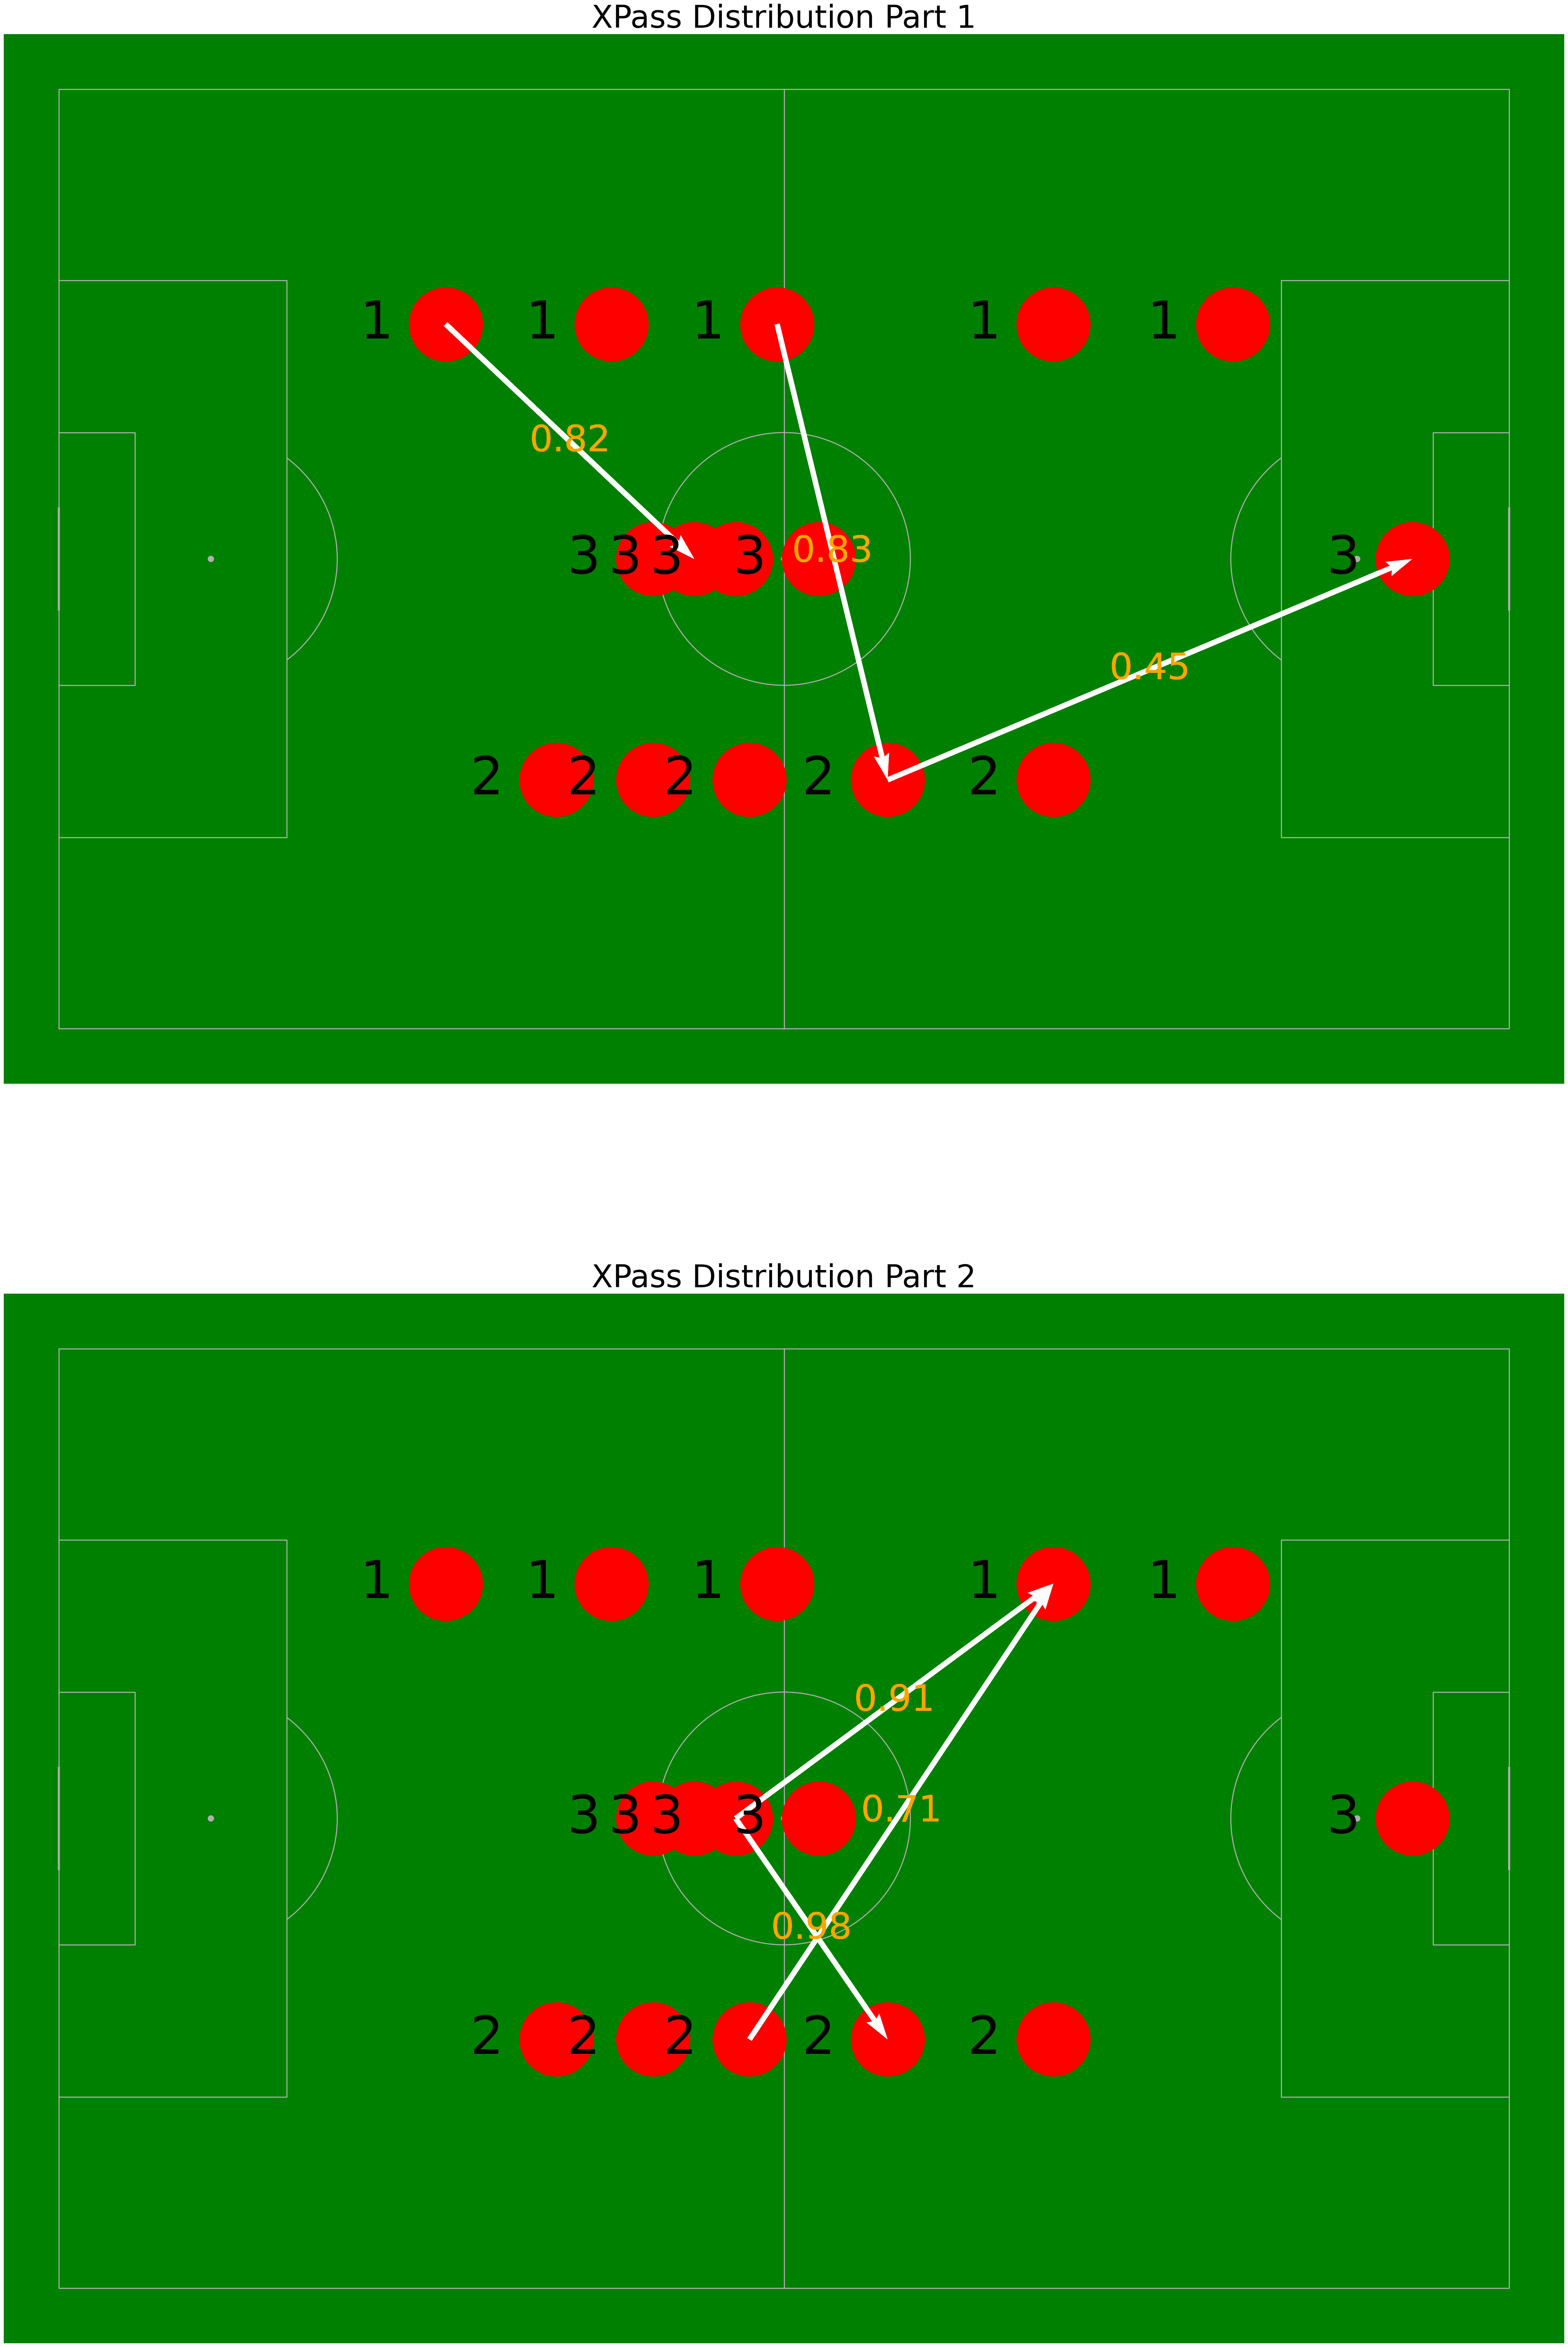

In [72]:
# PLOT PASS PROBABILITY INTO PITCH IMAGE
def plot_passing_probability_network(raw_input_from_csv, xpass_final_df):
    fig, axs = plt.subplots(2,1)
    fig.set_figheight(80)
    fig.set_figwidth(100)
    pitchXPass_part1 = Pitch(pitch_type="custom", pitch_length=105, pitch_width=68, pitch_color="green")
    pitchXPass_part1.draw(axs[0], figsize=(200,100), constrained_layout=True, tight_layout=False)
    axs[0].set_title("XPass Distribution Part 1", fontsize=60)
    pitchXPass_part2 = Pitch(pitch_type="custom", pitch_length=105, pitch_width=68, pitch_color="green")
    pitchXPass_part2.draw(axs[1], figsize=(200,100), constrained_layout=True, tight_layout=False)
    axs[1].set_title("XPass Distribution Part 2", fontsize=60)

    timestamps_sorted = sorted(raw_input_from_csv['timestamp'].unique())
    for timestamp in timestamps_sorted:
        raw_input_this_timestamp = raw_input_from_csv[raw_input_from_csv['timestamp'] == timestamp]
        unique_player_ids_this_timestamp = raw_input_this_timestamp['player_id'].unique()

        for player_id in unique_player_ids_this_timestamp:
            start_x = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_x"].iloc[0]
            start_y = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_y"].iloc[0]
            idx_column = 0
            for pitch in [pitchXPass_part1, pitchXPass_part2]:
                pitch.scatter(x=start_x, y=start_y, color="red", ax=axs[idx_column], s=20000)
                axs[idx_column].annotate(text=player_id, xy=(start_x - 5, start_y), ha="center", va="center", size=100)
                idx_column += 1

        list_unique_arrows = []
        for player_id_src in unique_player_ids_this_timestamp:
            for player_id_target in unique_player_ids_this_timestamp:
                if player_id_src == player_id_target:
                    continue
                if ((player_id_src, player_id_target) not in list_unique_arrows) and ((player_id_target, player_id_src) not in list_unique_arrows):
                    list_unique_arrows.append((player_id_src, player_id_target))
                    pitch = pitchXPass_part1
                    idx_column = 0
                else:
                    pitch = pitchXPass_part2
                    idx_column = 1
                specific_row_xpass_df = xpass_final_df.loc[(xpass_final_df["player_id_src"] == player_id_src) & (xpass_final_df["player_id_target"] == player_id_target), ["start_x", "start_y", "end_x", "end_y", "probability_score"]].iloc[0]
                pitch.arrows(xstart=specific_row_xpass_df["start_x"], ystart=specific_row_xpass_df["start_y"], xend=specific_row_xpass_df["end_x"], yend=specific_row_xpass_df["end_y"], ax=axs[idx_column], color="white", width=10)
                x_line = (specific_row_xpass_df["end_x"] + specific_row_xpass_df["start_x"]) / 2
                y_line = (specific_row_xpass_df["end_y"] + specific_row_xpass_df["start_y"]) / 2   
                axs[idx_column].annotate(text=str(round(specific_row_xpass_df["probability_score"], 2)), xy=(x_line, y_line), ha="center", va="center", size=70, color="orange")
    
    plt.show()

plot_passing_probability_network(raw_input_coordinate_player_df, xpass_dataframes_test)

In [73]:
# FUNCTION TO PREPROCESS FINAL XGOAL DATAFRAME
def preprocess_xgoal_test(xgoal_df):
    # 1. Change start_x, start_y, end_x, end_y with StandardScaler
    # scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    columns = ["distance_to_goal", "angle_to_goal"]
    xgoal_df[columns] = scaler.fit_transform(xgoal_df[columns])

    # 2. Change incorrect type of bodypart_id and is_home_team columns
    xgoal_df['bodypart_id'] = xgoal_df['bodypart_id'].astype("int64")
    xgoal_df['is_home_team'] = xgoal_df['is_home_team'].astype("int64")

    return xgoal_df

# FUNCTION TO UPDATE XGOAL VALUE TO LIST FINAL PATHS OBJECTS (Path_Decision_Making class)
def update_xgoal_value_to_list_path_objects(list_path_objects, xgoal_dataframes_test):
    for path_idx, path_object in enumerate(list_path_objects):
        # Updates xgoal_value in list of node class
        node_objects_list = path_object.get_path_list()
        for node_object in node_objects_list:
            player_id = node_object.get_player_id()
            timestamp = node_object.get_timestamp()
            xgoal_value = xgoal_dataframes_test.loc[(xgoal_dataframes_test["player_id"] == player_id) & \
                             (xgoal_dataframes_test["timestamp"] == timestamp) & \
                             (xgoal_dataframes_test["path_id"] == path_idx), "probability_score"].iloc[0]
            node_object.set_xgoal_value(xgoal_value)
        # Updates xgoal_value in xpass class
        xpass_objects = path_object.get_xpass_values()
        for xpass_object in xpass_objects:
            player_id_src = xpass_object.get_node_start().get_player_id()
            timestamp_src = xpass_object.get_node_start().get_timestamp()
            xgoal_value_src = xgoal_dataframes_test.loc[(xgoal_dataframes_test["player_id"] == player_id_src) & \
                             (xgoal_dataframes_test["timestamp"] == timestamp_src) & \
                             (xgoal_dataframes_test["path_id"] == path_idx), "probability_score"].iloc[0]
            xpass_object.get_node_start().set_xgoal_value(xgoal_value_src)

            player_id_target = xpass_object.get_node_end().get_player_id()
            timestamp_target = xpass_object.get_node_end().get_timestamp()
            xgoal_value_target = xgoal_dataframes_test.loc[(xgoal_dataframes_test["player_id"] == player_id_target) & \
                             (xgoal_dataframes_test["timestamp"] == timestamp_target) & \
                             (xgoal_dataframes_test["path_id"] == path_idx), "probability_score"].iloc[0]
            xpass_object.get_node_end().set_xgoal_value(xgoal_value_target)
    return list_path_objects

# VERIFY XGOAL PROBABILITY BASED ON MODEL
filename = "xgbRegressor_xgoal_model.sav"
directory_model = "data/model_xgoal_wyscout/"
xgoal_model = pickle.load(open(directory_model + filename, 'rb'))
filename_df_with_score = "xgoal_dataframes_test_result.csv"

xgoal_dataframes_test_verify = xgoal_dataframes_test.copy(deep=True)
xgoal_dataframes_test_verify = preprocess_xgoal_test(xgoal_dataframes_test_verify)
featured_column_based_on_model = ["distance_to_goal", "angle_to_goal", "is_home_team", "bodypart_id"]
X_test = xgoal_dataframes_test_verify[featured_column_based_on_model]
y_verify_result = xgoal_model.predict(X_test)

xgoal_dataframes_test['probability_score'] = y_verify_result
final_list_paths_obj = update_xgoal_value_to_list_path_objects(final_list_paths_obj, xgoal_dataframes_test)
xgoal_dataframes_test.to_csv(directory_model + filename_df_with_score)
xgoal_dataframes_test

,path_id,timestamp,player_id,distance_to_goal,angle_to_goal,is_home_team,bodypart_id,probability_score
0,26,5,3,7.000000,0.963531,1,0,0.718553
1,26,4,3,50.000000,0.146139,1,0,0.197934
2,26,3,3,56.000000,0.130529,1,0,0.197934
3,26,2,3,59.000000,0.123909,1,0,0.182387
4,26,1,1,78.854296,0.090594,1,0,0.110204
...,...,...,...,...,...,...,...,...
130,0,5,3,7.000000,0.963531,1,0,0.718553
131,0,4,1,37.121422,0.175203,1,0,0.197934
132,0,3,1,55.659680,0.125116,1,0,0.197934
133,0,2,1,67.186308,0.105328,1,0,0.185619


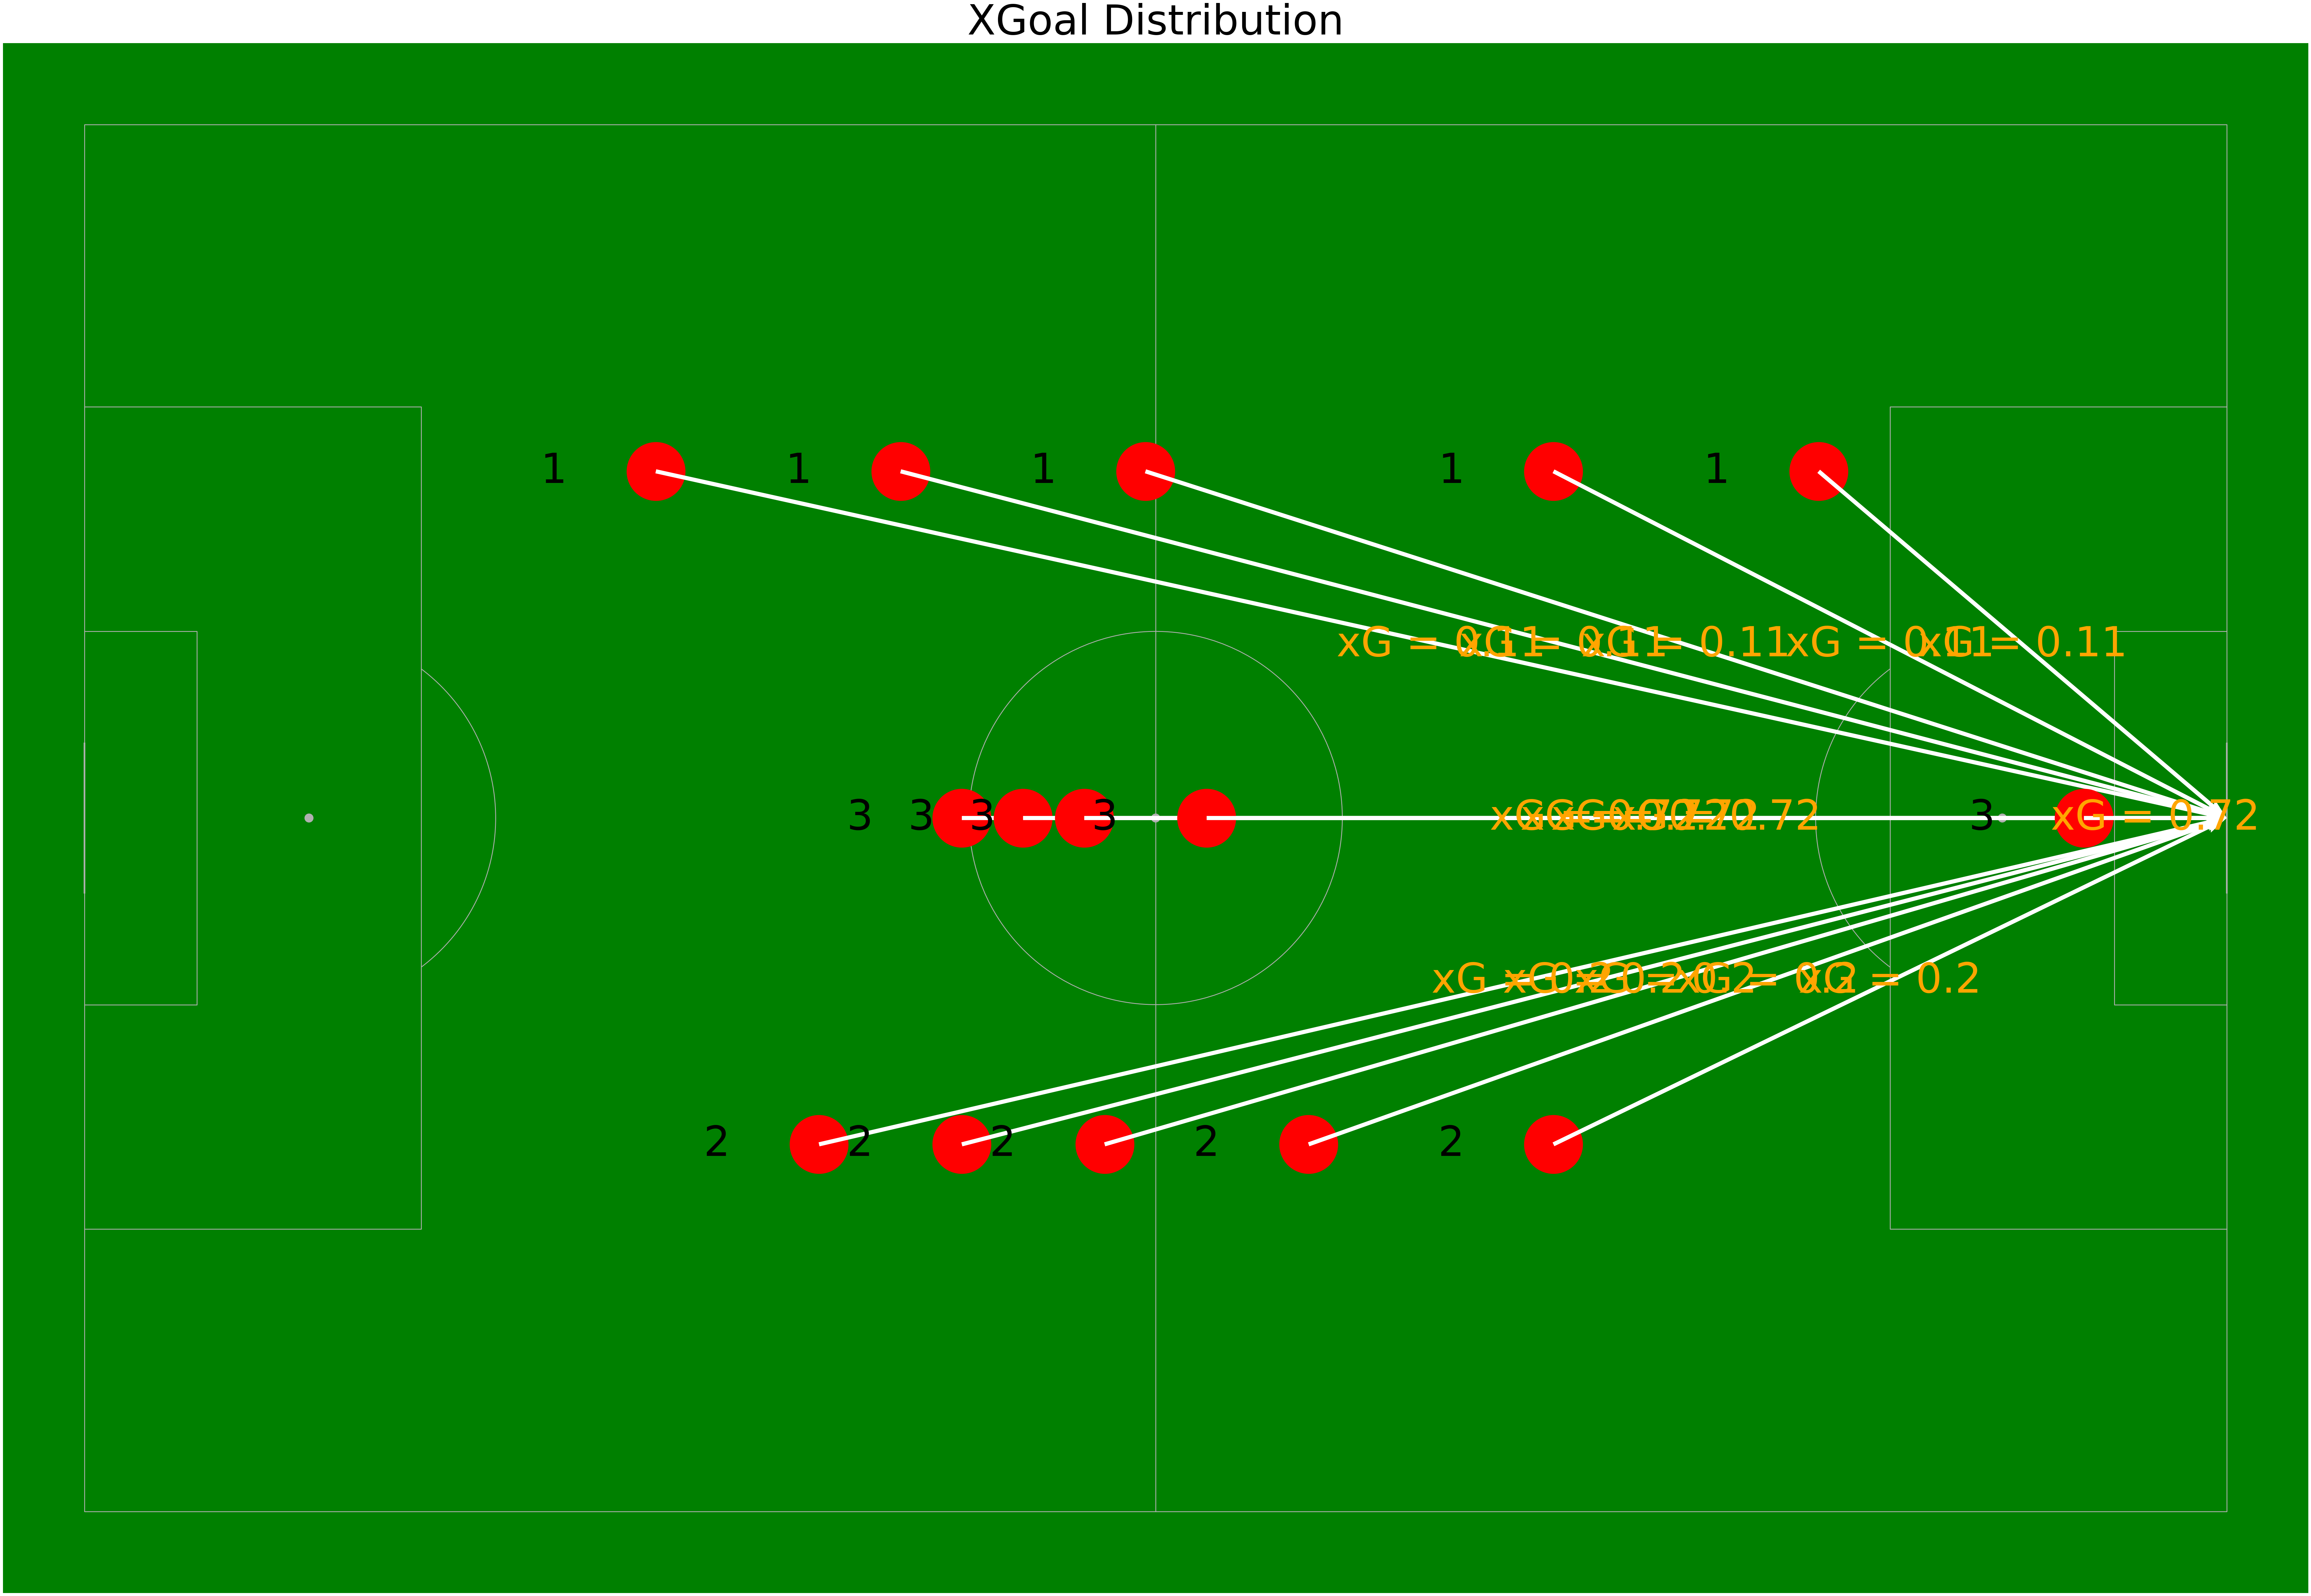

In [74]:
# PLOT GOAL PROBABILITY INTO PITCH IMAGE
def plot_goal_probability_network(raw_input_from_csv, xgoal_final_df):
    pitchXGoal = Pitch(pitch_type="custom", pitch_length=105, pitch_width=68, pitch_color="green")
    fig, ax = pitchXGoal.draw(figsize=(100,80), constrained_layout=True, tight_layout=False)
    ax.set_title("XGoal Distribution", fontsize=100)

    timestamps_sorted = sorted(raw_input_from_csv['timestamp'].unique())
    for timestamp in timestamps_sorted:
        raw_input_this_timestamp = raw_input_from_csv[raw_input_from_csv['timestamp'] == timestamp]
        unique_player_ids_this_timestamp = raw_input_this_timestamp['player_id'].unique()

        for player_id in unique_player_ids_this_timestamp:
            start_x = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_x"].iloc[0]
            start_y = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_y"].iloc[0]
            pitchXGoal.scatter(x=start_x, y=start_y, color="red", ax=ax, s=20000)
            ax.annotate(text=player_id, xy=(start_x - 5, start_y), ha="center", va="center", size=100)

        for player_id in unique_player_ids_this_timestamp:
            specific_row_xgoal_df = xgoal_final_df.loc[xgoal_final_df["player_id"] == player_id, ["is_home_team", "probability_score"]].iloc[0]
            start_x = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_x"].iloc[0]
            start_y = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_y"].iloc[0]
            end_x = 105 if (specific_row_xgoal_df['is_home_team'] == 1) else 0
            end_y = 34

            pitchXGoal.arrows(xstart=start_x, ystart=start_y, xend=end_x, yend=end_y, ax=ax, color="white", width=10)
            x_line = (end_x + start_x) / 2
            y_line = (end_y + start_y) / 2   
            ax.annotate(text=("xG = " + str(round(specific_row_xgoal_df["probability_score"], 2))), xy=(x_line, y_line), ha="center", va="center", size=100, color="orange")
    
    plt.show()

plot_goal_probability_network(raw_input_coordinate_player_df, xgoal_dataframes_test)